<a href="https://colab.research.google.com/github/kyangleo/STATS-507/blob/main/stats507final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q "transformers>=4.45.0" "datasets>=3.0.0" \
                "accelerate>=1.0.0" "evaluate>=0.4.0" \
                scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

import torch

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(SEED)

print("PyTorch version", torch.__version__)
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")

PyTorch version 2.9.0+cu126
GPU is available


In [4]:
imdb = load_dataset("imdb")
imdb

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
print(imdb["train"][0]["text"][:500])
print("Label:", imdb["train"][0]["label"])

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attent
Label: 0


In [6]:
label2str = {0: "negative", 1: "positive"}

In [7]:
# 10% train data for validation
train_valid = imdb["train"].train_test_split(test_size=0.1, seed=SEED)
train_dataset = train_valid["train"]
valid_dataset = train_valid["test"]
test_dataset = imdb["test"]

print(train_dataset)
print(valid_dataset)
print(test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 22500
})
Dataset({
    features: ['text', 'label'],
    num_rows: 2500
})
Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})


In [8]:
# EDA
def review_length(text):
  return len(text.split())

lengths = [review_length(text) for text in train_dataset["text"]]

print("Number of training reviews:", len(lengths))
print("Average length:", np.mean(lengths))
print("Median length:", np.median(lengths))
print("Min length:", np.min(lengths))
print("Max length:", np.max(lengths))

Number of training reviews: 22500
Average length: 234.39706666666666
Median length: 174.0
Min length: 10
Max length: 2470


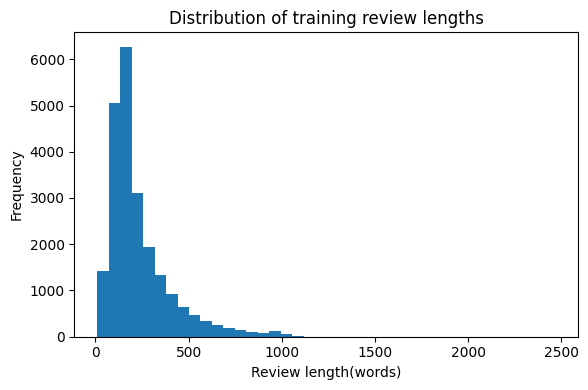

In [9]:
plt.figure(figsize=(6,4))
plt.hist(lengths, bins=40)
plt.xlabel("Review length(words)")
plt.ylabel("Frequency")
plt.title("Distribution of training review lengths")
plt.tight_layout()
plt.show()

In [10]:
from collections import Counter

train_label_counts = Counter(train_dataset["label"])
valid_label_counts = Counter(valid_dataset["label"])
test_label_counts = Counter(test_dataset["label"])

print("Training label counts:", train_label_counts)
print("Validation label counts:", valid_label_counts)
print("Test label counts:", test_label_counts)
# The dataset is approximately balanced with 25,000 positive and
# 25,000 negative movie reviews in total.

Training label counts: Counter({0: 11257, 1: 11243})
Validation label counts: Counter({1: 1257, 0: 1243})
Test label counts: Counter({0: 12500, 1: 12500})


In [11]:
# small scale for quick test
small_train = train_dataset.shuffle(SEED).select(range(2000))
small_valid = valid_dataset.shuffle(SEED).select(range(1000))
small_test = test_dataset.shuffle(SEED).select(range(1000))

small_train, small_valid, small_test

(Dataset({
     features: ['text', 'label'],
     num_rows: 2000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1000
 }))

In [12]:
USE_SMALL = True

if USE_SMALL:
  dataset_train = small_train
  dataset_valid = small_valid
  dataset_test = small_test
else:
  dataset_train = train_dataset
  dataset_valid = valid_dataset
  dataset_test = test_dataset

len(dataset_train), len(dataset_valid), len(dataset_test)

(2000, 1000, 1000)

In [13]:
X_train = dataset_train["text"]
y_train = dataset_train["label"]

X_valid = dataset_valid["text"]
y_valid = dataset_valid["label"]

X_test = dataset_test["text"]
y_test = dataset_test["label"]

print("Example review:", X_train[0][:300])
print("Example label:", label2str[y_train[0]])

Example review: Most of the Atomic Age monster movies I saw on television as a kid- and some of them, THE BLOB included, scared the daylights outta me. Movies like INVADERS FROM MARS made it all too clear to us "small fry" that kids just weren't to be trusted when it came to things like things invading the Homeworl
Example label: positive


In [14]:
# TF-IDF + Logistic Regression Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [15]:
baseline_clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=50000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("logreg", LogisticRegression(
        max_iter=200,
        n_jobs=-1,
        C=1.0
    ))
])

baseline_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('logreg', LogisticRegression(max_iter=200, n_jobs=-1))])

In [16]:
y_valid_pred = baseline_clf.predict(X_valid)

acc_valid = accuracy_score(y_valid, y_valid_pred)
print(f"Validation accuracy (baseline): {acc_valid: .4f}")

print("\nValidation classification report:")
print(classification_report(y_valid, y_valid_pred, target_names=["negative", "positive"]))

Validation accuracy (baseline):  0.8430

Validation classification report:
              precision    recall  f1-score   support

    negative       0.86      0.81      0.83       484
    positive       0.83      0.88      0.85       516

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



In [17]:
y_test_pred = baseline_clf.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy (baseline): {acc_test: .4f}")

print("\nTest classification report:")
print(classification_report(y_test, y_test_pred, target_names=["negative", "positive"]))

Test accuracy (baseline):  0.8210

Test classification report:
              precision    recall  f1-score   support

    negative       0.85      0.79      0.82       512
    positive       0.79      0.85      0.82       488

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



In [18]:
# Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
cm

array([[404, 108],
       [ 71, 417]])

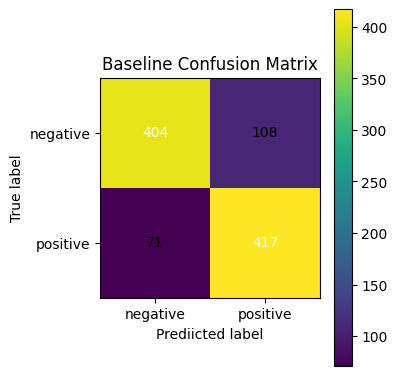

In [19]:
def plot_confusion_matrix(cm, class_names):
  fig, ax = plt.subplots(figsize=(4,4))
  im = ax.imshow(cm, interpolation="nearest")
  plt.colorbar(im)

  ax.set_xticks(np.arange(len(class_names)))
  ax.set_yticks(np.arange(len(class_names)))
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)

  ax.set_xlabel("Prediicted label")
  ax.set_ylabel("True label")
  ax.set_title("Baseline Confusion Matrix")

  thresh = cm.max() / 2
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j], 'd'),
              ha="center", va="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.show()

plot_confusion_matrix(cm, ["negative", "positive"])